In [1]:
import torch
import torch
from torch.autograd import Variable as V
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
import numpy as np
import argparse
import time
torch.__version__
# WOOO!
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
LATENT_DIM = 32
BATCH_SIZE = 100

In [3]:
train_dataset = datasets.MNIST(root='./data/',
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = datasets.MNIST(root='./data/',
                           train=False, 
                           transform=transforms.ToTensor())

print(len(train_dataset))
print(len(test_dataset))
# train_dataset[0][0]

torch.manual_seed(3435)
train_img = torch.stack([d[0] for d in train_dataset])
train_label = torch.LongTensor([d[1] for d in train_dataset])
test_img = torch.stack([d[0] for d in test_dataset])
test_label = torch.LongTensor([d[1] for d in test_dataset])
# print(train_img[0])
print(train_img.size(), train_label.size(), test_img.size(), test_label.size())

# MNIST does not have an official train dataset. So we will use the last 10000 training points as your validation set.
val_img = train_img[-10000:].clone()
val_label = train_label[-10000:].clone()
train_img = train_img[:-10000] # TODO: this should be -10000 right?
train_label = train_label[:-10000]

train = torch.utils.data.TensorDataset(train_img, train_label)
val = torch.utils.data.TensorDataset(val_img, val_label)
test = torch.utils.data.TensorDataset(test_img, test_label)
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

img, label = next(iter(train_loader))
print(img.size(),label.size())

60000
10000
torch.Size([60000, 1, 28, 28]) torch.Size([60000]) torch.Size([10000, 1, 28, 28]) torch.Size([10000])
torch.Size([100, 1, 28, 28]) torch.Size([100])


In [4]:
from gan_models import Generator, Discriminator
G = Generator()
D = Discriminator()
G.cuda()
D.cuda()
G.load_state_dict(torch.load('../HW4/stupidg.pkl'))
D.load_state_dict(torch.load('../HW4/stupidd.pkl'))

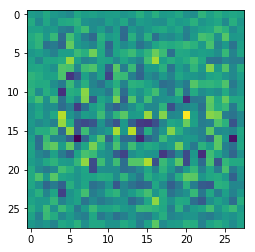

In [14]:
# viz 1: generate a digit
seed_distribution = Normal(V(torch.zeros(1,LATENT_DIM)).cuda(), 
                        V(torch.ones(1,LATENT_DIM)).cuda())
def graph_gan():
    seed = seed_distribution.sample()
    x = G(seed) # 1,28,28
    plt.imshow(x.squeeze().cpu().data.numpy())
    
graph_gan()

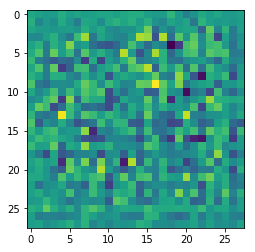

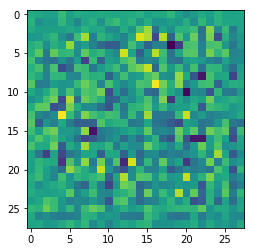

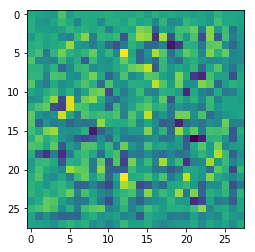

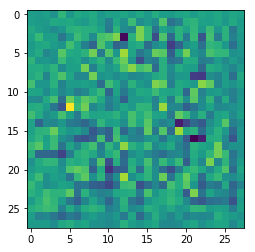

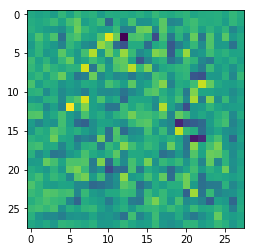

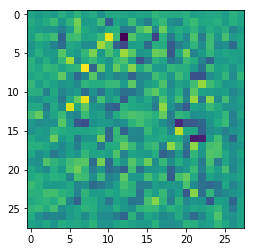

In [16]:
# viz 2
z1 = seed_distribution.sample()
z2 = seed_distribution.sample()
all = []
for k in np.arange(0,1.1,0.2):
    z = k * z1 + (1 - k) * z2
    x = G(z.cuda())
    all.append(x.squeeze().cpu().data.numpy()) # TODO: might not work
    plt.imshow(x.squeeze().cpu().data.numpy())
    plt.show()

In [17]:
# viz 4--only if latent dimensionality is 2
# for each point in the grid, generate x and show digit in 2d plot
# taken from altosaar demo on github
assert(LATENT_DIM==2) # this only works if latent dim is 2 dimensional
nx = ny = 20
x_values = np.linspace(-2, 2, nx) # sasha suggests -2,2 and altosaar uses -3,3
y_values = np.linspace(-2, 2, ny)
canvas = np.empty((28 * ny, 28 * nx))
for ii, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        np_z = np.array([[xi, yi]])
        x_mean = G(torch.cuda.FloatTensor(np_z))
        canvas[(nx - ii - 1) * 28:(nx - ii) * 28, j *
               28:(j + 1) * 28] = x_mean[0].data.reshape(28, 28)
# imsave('prior_predictive_map_frame_%d.png', canvas)
plt.figure(figsize=(8, 10))
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper")
plt.tight_layout()
# plt.savefig()

AssertionError: 